In [51]:
import matplotlib.pyplot as plt
import numpy as np
import os
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
import csv
from tqdm import tqdm

%matplotlib notebook

In [9]:
def load_csv(pth):
    return np.loadtxt(pth, dtype=object, skiprows=1, delimiter=",")

## IDEA 1
Try and cluster the data into multiple categories of people depending on what their background is

In [3]:
path_to_bbc_data = os.path.join("..", "data", "bbc-pandemic")

over18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_o18.csv"))
under18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_u18.csv"))

<IPython.core.display.Javascript object>


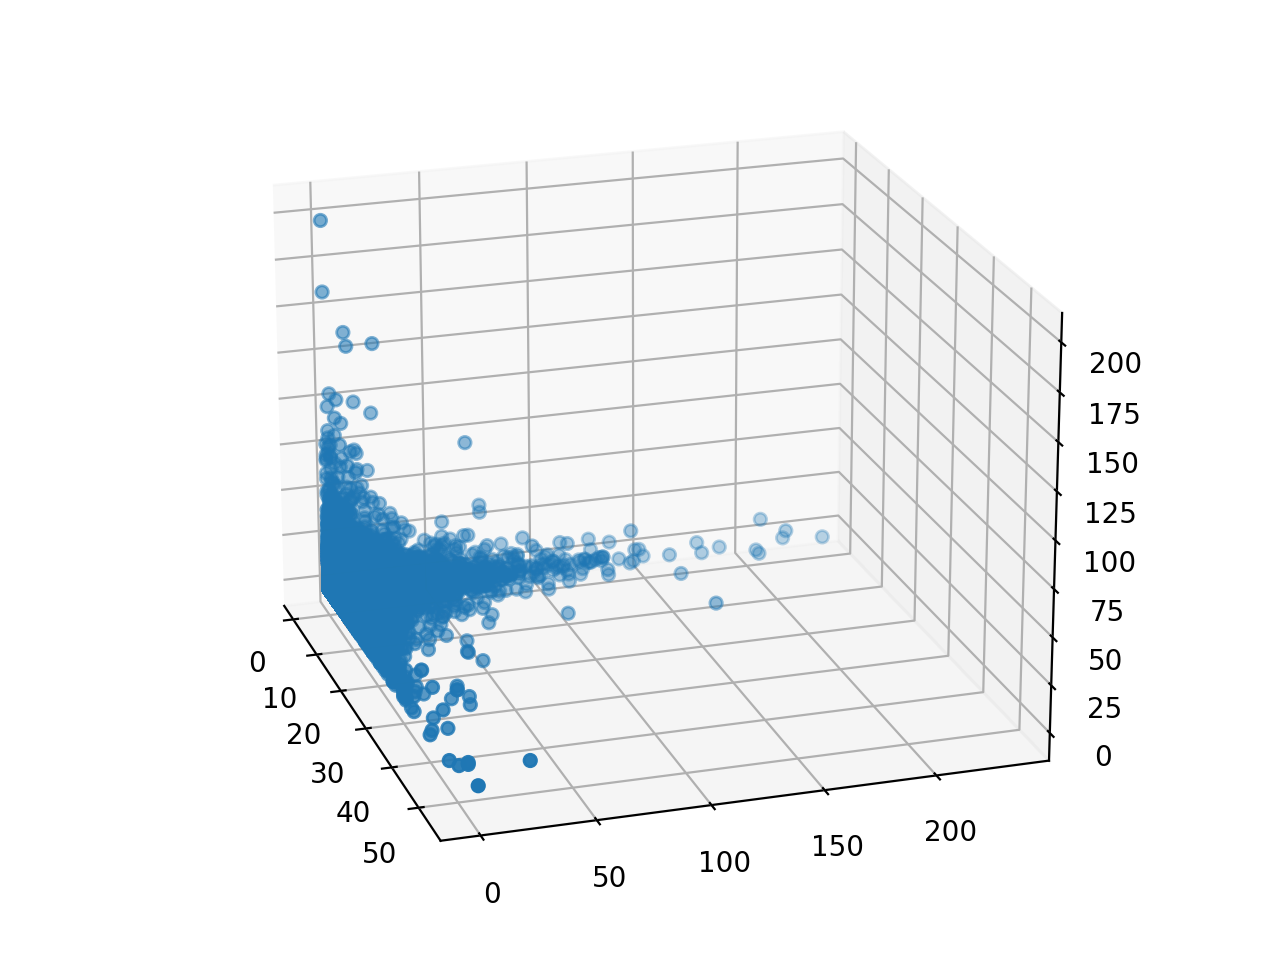

In [5]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(over18[:, 0], over18[:, 1], over18[:, 2])
plt.show()

<IPython.core.display.Javascript object>


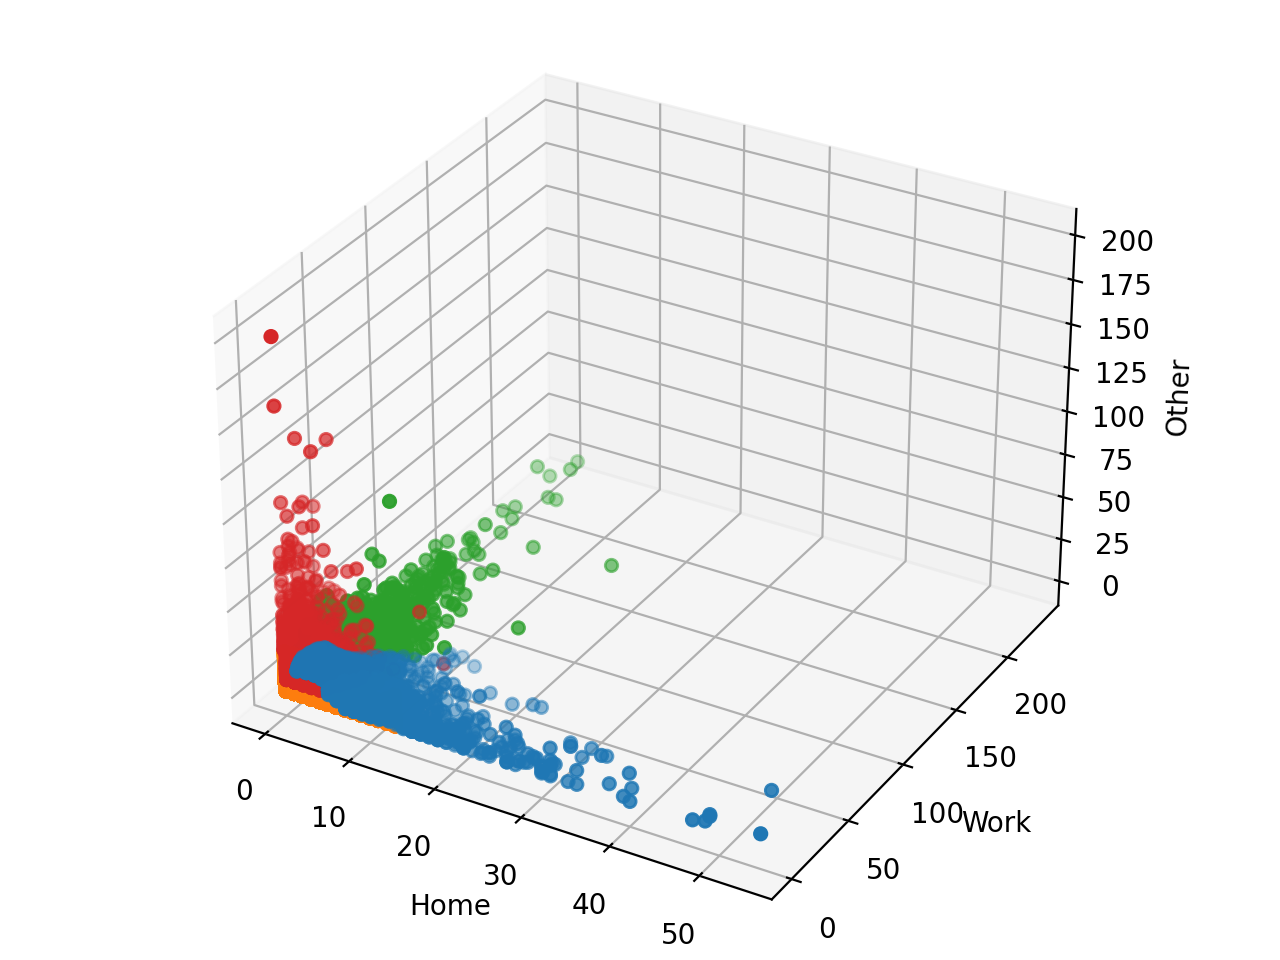

In [7]:
# Clusters
# Home, Work, Other
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from numpy import unique
from numpy import where

model = GaussianMixture(n_components=5)
model.fit(over18)
yhat = model.predict(over18)
clusters = unique(yhat)

fig = plt.figure()
ax = Axes3D(fig)

for cluster in clusters:
    row_ix = where(yhat == cluster)
    ax.scatter(over18[row_ix, 0], over18[row_ix, 1], over18[row_ix, 2])
    ax.set_xlabel("Home")
    ax.set_ylabel("Work")
    ax.set_zlabel("Other")
plt.show()


## Idea 2
Preprocess the data from POLYMOD into the correct type

In [39]:
path_to_polymod = os.path.join("..", "data", "polymod")

types = ["Children not attending school", "Children attending school",
        "University students", "Non university 18-31", 
        "31-50", "51-70", "71+"]

CHILD_NO_SCHOOL = 0
CHILD_SCHOOL = 1
UNIVERSITY = 2
TWENTIES = 3
THIRTIES_TO_FIFTY = 4
FIFTIES_TO_SEVENTY = 5
SEVENTYPLUS = 6

participant_info = load_csv(os.path.join(path_to_polymod, "participant_common.csv"))
participant_extra = load_csv(os.path.join(path_to_polymod, "participant_extra.csv"))

participant_to_age = {}
participant_to_category = {}

for participant in participant_info:
    pid = participant[0]
    if(not pid or pid.isspace() or not participant[2] or participant[2].isspace()):
        continue
    
    participant_to_age[int(pid)] = int(participant[2])
    
for participant in participant_extra:
    if(not participant[0] or participant[0].isspace() or not participant[2] or participant[2].isspace()):
        continue
        
    pid = int(participant[0])
    occ = int(participant[2])
    
    if(pid not in participant_to_age):
        continue
        
    age = participant_to_age[pid]
    
    if(age > 70):
        participant_to_category[pid] = SEVENTYPLUS
    
    elif(age > 50):
        participant_to_category[pid] = FIFTIES_TO_SEVENTY
        
    elif(age > 30):
        participant_to_category[pid] = THIRTIES_TO_FIFTY
        
    elif(age > 18 and occ != 5):
        participant_to_category[pid] = TWENTIES
    
    elif(age > 18 and occ == 5):
        participant_to_category[pid] = UNIVERSITY
        
    elif(age < 18 and occ != 5):
        participant_to_category[pid] = CHILD_NO_SCHOOL
    
    else:
        participant_to_category[pid] = CHILD_SCHOOL

s = (participant_to_category.values())
a = list(Counter(s).keys())
s2 = np.argsort(a)
b = np.array(list(Counter(s).values()))[s2]
a = np.array(a)[s2]


for i in a:
    print(types[i] + ": " + str(b[i]))



Children not attending school: 953
Children attending school: 1637
University students: 309
Non university 18-31: 732
31-50: 1696
51-70: 1516
71+: 216


In [54]:
contacts = load_csv(os.path.join(path_to_polymod, "contact_common.csv"))

participants_to_contacts = {}

for contact in contacts:
    if(not contact[0] or not contact[2] or contact[2]=="NA"):
        continue
    
    pid = int(contact[0])
    age = int(contact[2])
    
    if pid not in participant_to_category:
        continue
        
    p_type = participant_to_category[pid] 
    
    home = (contact[6] == "TRUE")
    work = (contact[7] == "TRUE") or (contact[8] == "TRUE")
    other = (contact[9] == "TRUE") or (contact[10] == "TRUE") or (contact[11] == "TRUE")
    
    s = 1 + (7*int(home)) + (7*int(work))
    
    if(pid not in participants_to_contacts):
        participants_to_contacts[pid] = [pid, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    
    x = participants_to_contacts[pid]

    if(age > 70):
        x[s + SEVENTYPLUS] += 1
    
    elif(age > 50):
        x[s + FIFTIES_TO_SEVENTY] += 1
        
    elif(age > 30):
        x[s + THIRTIES_TO_FIFTY] += 1
        
    elif(age > 18 and p_type == TWENTIES):
        x[s + TWENTIES] += 1
    
    elif(age > 18 and p_type == UNIVERSITY):
        x[s + UNIVERSITY] += 1
        
    elif(age < 18 and p_type == CHILD_NO_SCHOOL):
        x[s + CHILD_NO_SCHOOL] += 1
    
    else:
        x[s + CHILD_SCHOOL] += 1
    
    participants_to_contacts[pid] = x

In [55]:
with open ('../data/processed/childschool.csv', 'a') as child_school, open ('../data/processed/childnoschool.csv', 'a') as child_no_school, open ('../data/processed/university.csv', 'a') as university, open ('../data/processed/twenties.csv', 'a') as twenties, open ('../data/processed/thirtiestofifties.csv', 'a') as thirties_to_fifties, open ('../data/processed/fiftiestoseventies.csv', 'a') as fifties_to_seventies, open ('../data/processed/seventyplus.csv', 'a') as seventy_plus:
    writers = [child_school, child_no_school, university, twenties, thirties_to_fifties, fifties_to_seventies, seventy_plus]
    csv_writers = [csv.writer(w, dialect='excel') for w in writers]
    
    header = ["Participant ID", "Home - Child No School", "Home - Child School", "Home - University", "Home - 20s", "Home - 30s and 40s", "Home - 50s and 60s", "Home - 70+",
              "Work - Child No School", "Work - Child School", "Work - University", "Work - 20s", "Work - 30s and 40s", "Work - 50s and 60s", "Work - 70+",
              "Other - Child No School", "Other - Child School", "Other - University", "Other - 20s", "Other - 30s and 40s", "Other - 50s and 60s", "Other - 70+"]
    
    for csv_writer in csv_writers:
        csv_writer.writerow(header)
    
    
    for pid in tqdm(list(participants_to_contacts.keys())):
        val = participants_to_contacts[pid]
        
        if pid not in participant_to_category:
            continue
        category = participant_to_category[pid]
        
        csv_writer = csv_writers[category]
        csv_writer.writerow(val)
        
        
        

100%|██████████| 7016/7016 [00:00<00:00, 107863.99it/s]
